# Machine Learning with Signals Data

In this notebook we will be start using some of our machine learning techniques on signals data (audio).  We will be using a dataset consisting of recordings of spoken digits (0-9).  We will start by extracting some features from the signals and then apply our "traditional" ML algorithms, just as we did with our tabular data.  (In a future notebook we will see how to use ANNs to avoid needing to extract features.)<br><br>

If you are interested in playing around with more audio data like this, we encourage you to check out [UrbanSound](https://urbansounddataset.weebly.com).

In [24]:
! git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 3166 (delta 3), reused 8 (delta 3), pack-reused 3157
Receiving objects: 100% (3166/3166), 23.92 MiB | 25.92 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [25]:
!ls free-spoken-digit-dataset/recordings/

0_jackson_0.wav    2_theo_0.wav       5_jackson_0.wav	 7_theo_0.wav
0_jackson_10.wav   2_theo_10.wav      5_jackson_10.wav	 7_theo_10.wav
0_jackson_11.wav   2_theo_11.wav      5_jackson_11.wav	 7_theo_11.wav
0_jackson_12.wav   2_theo_12.wav      5_jackson_12.wav	 7_theo_12.wav
0_jackson_13.wav   2_theo_13.wav      5_jackson_13.wav	 7_theo_13.wav
0_jackson_14.wav   2_theo_14.wav      5_jackson_14.wav	 7_theo_14.wav
0_jackson_15.wav   2_theo_15.wav      5_jackson_15.wav	 7_theo_15.wav
0_jackson_16.wav   2_theo_16.wav      5_jackson_16.wav	 7_theo_16.wav
0_jackson_17.wav   2_theo_17.wav      5_jackson_17.wav	 7_theo_17.wav
0_jackson_18.wav   2_theo_18.wav      5_jackson_18.wav	 7_theo_18.wav
0_jackson_19.wav   2_theo_19.wav      5_jackson_19.wav	 7_theo_19.wav
0_jackson_1.wav    2_theo_1.wav       5_jackson_1.wav	 7_theo_1.wav
0_jackson_20.wav   2_theo_20.wav      5_jackson_20.wav	 7_theo_20.wav
0_jackson_21.wav   2_theo_21.wav      5_jackson_21.wav	 7_theo_21.wav
0_jackson_22.wav   2_the

In [26]:
# You may not have to run this cell
import os
os.chdir('free-spoken-digit-dataset/recordings')

In [27]:
print('{} data points\n'.format(len(os.listdir())))

# list the first few files
os.listdir()[:15]


2000 data points



['1_yweweler_39.wav',
 '6_theo_43.wav',
 '4_yweweler_1.wav',
 '6_theo_6.wav',
 '2_nicolas_2.wav',
 '3_nicolas_46.wav',
 '8_yweweler_7.wav',
 '2_theo_23.wav',
 '7_nicolas_31.wav',
 '9_yweweler_17.wav',
 '0_yweweler_32.wav',
 '6_nicolas_14.wav',
 '5_yweweler_34.wav',
 '1_theo_23.wav',
 '7_theo_30.wav']

In [28]:
import pandas as pd
import numpy as np
from scipy import signal
import scipy.io.wavfile
import scipy.stats.mstats as mstats
from IPython.display import Audio
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import matplotlib
from sklearn import metrics

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16,'figure.figsize':(10,6)})

!pip install graphviz 
!apt-get install graphviz
import graphviz


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [29]:
def plot_FT(ft, T, N):
  """
  Define a Function that will plot the Fourier Transform frequency spectrum
  :param ft: output of Fourier Transform (i.e., np.fft.fft())
  :param T: sample resolution (in seconds). The sample resolution is the number of bits per sample and tells how loud the sound file can be. More info can be found here: http://www.asel.udel.edu/speech/tutorials/instrument/sam_res.html
  :param N: total number of samples
  """
  
  f = np.linspace(0, 1 / T, N)
  plt.plot(f[:N // 2], np.abs(ft)[:N // 2] * 2 / N) 
  plt.ylabel("Amplitude")
  plt.xlabel("Frequency [Hz]")

Let's take a look at one of the files and see what it "looks" like.

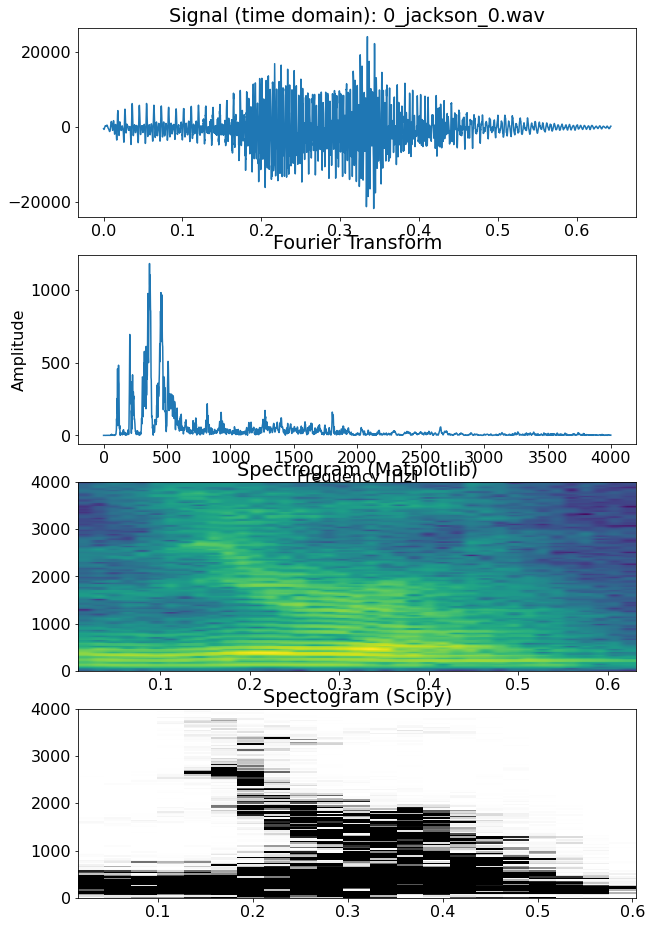

In [30]:
sample_file = '0_jackson_0.wav'

(sample_rate, y) = scipy.io.wavfile.read(sample_file)

t = np.arange(0, len(y)/sample_rate, 1/sample_rate)

# Fourier Transform
fft=np.fft.fft(y)

# Spectogram
sample_freq, segment_time, spec_data = signal.spectrogram(y,sample_rate)



# PLOT ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.figure(figsize=(10,16))

plt.subplot(4,1,1)
plt.plot(t,y)
plt.title('Signal (time domain): {}'.format(sample_file))

plt.subplot(4,1,2)
plot_FT(fft,t[1]-t[0],len(y))
plt.title('Fourier Transform')

plt.subplot(4,1,3)
specgram(y,Fs=sample_rate)
plt.title('Spectrogram (Matplotlib)')

plt.subplot(4,1,4)
plt.pcolormesh(segment_time, sample_freq, spec_data,cmap='Greys',vmax=600)
plt.title('Spectogram (Scipy)')
plt.show()

In [31]:
Audio(data=y, rate=sample_rate)

## Feature Extraction
Let's extract some features that are useful in signals processing.

### Spectral Centroid

The [**spectral centroid**](https://en.wikipedia.org/wiki/Spectral_centroid) indicates at which frequency the energy of a spectrum is centered upon. This is like a weighted mean:
$$f_c=\frac{\sum_kA(k)f(k)}{\sum_kA(k)}$$
 
where $A(k)$ is the spectral magnitude at frequency bin $k$,  $f(k)$ is the frequency at bin $k$
 .

In [32]:
def spectral_centroid(fft,T):
  N = len(fft)
  f = np.linspace(0, 1 / T, N)
  
  freq = f[:N // 2]
  mag = np.abs(fft)[:N // 2] * 2 / N
  
  return np.sum(mag*freq)/np.sum(mag)         # return weighted sum
  

### Spectral Flatness

The [**spectral flatness**](https://en.wikipedia.org/wiki/Spectral_flatness), also known as Wiener entropy, is a measure used in digital signal processing to characterize an audio spectrum. Spectral flatness is typically measured in decibels, and provides a way to quantify how noise-like a sound is, as opposed to being tone-like.

In [33]:
def spectral_flatness(fft): 
  N = len(fft) 
  magnitude = abs(fft[:N//2])* 2 / N 
  sf = mstats.gmean(magnitude) / np.mean(magnitude) 
  
  return sf

### Maximum Frequency Value
The frequency at maximum altitude isn't necessarily a particularly informative feature, but it's easy to extract.

In [34]:
def max_freq(fft,T):
  N = len(fft)
  f = np.linspace(0, 1 / T, N)
  
  freq = f[1:N // 2]
  mag = np.abs(fft)[1:N // 2] * 2 / N
  
  return freq[np.argmax(mag)]

This what our one data point looks like in our dataframe:

In [35]:
import re


# regex the file names to get the digit, speaker, and trial
re_digit = re.compile('\d+_')
re_speaker = re.compile('_[a-z]+_')
re_trial = re.compile('_\d.')

digit = re.match( re_digit, sample_file)[0][:-1]
speaker = re.search( re_speaker, sample_file)[0][1:-1]
trial = re.search( re_trial, sample_file)[0][1:-1]

# load into dataframe
df = pd.DataFrame(columns=['file','digit','speaker','trial','SC','SF','MF'])
sc = spectral_centroid(fft,t[1]-t[0])
sf = spectral_flatness(fft)
mf = max_freq(fft,t[1]-t[0])


df = df.append({'file':sample_file,'digit':digit,'speaker':speaker,'trial':trial,'SC':sc,'SF':sf,'MF':mf},ignore_index=True)
df

,file,digit,speaker,trial,SC,SF,MF
0,0_jackson_0.wav,0,jackson,0,849.769263,0.306077,362.15271


## Load full dataset and extract features

In [36]:
import re

re_digit = re.compile('\d+_')
re_speaker = re.compile('_[a-z]+_')
re_trial = re.compile('_\d+.')

df = pd.DataFrame(columns=['file','digit','speaker','trial','SC','SF','MF'])

for sample_file in os.listdir():
  try:
    
    digit = int(re.match( re_digit, sample_file)[0][:-1])
    speaker = re.search( re_speaker, sample_file)[0][1:-1]
    trial = int(re.search( re_trial, sample_file)[0][1:-1])

    # read the file
    (sample_rate, y) = scipy.io.wavfile.read(sample_file)
    
    # some files have two channels... just take the first
    if len(y.shape) == 2:
      y = y[:,0]
    
    t = np.arange(0, len(y)/sample_rate, 1/sample_rate)

    # Fourier Transform
    fft=np.fft.fft(y)

    # calculate features
    sc = spectral_centroid(fft,t[1]-t[0])
    sf = spectral_flatness(fft)
    mf = max_freq(fft,t[1]-t[0])

    # add to our dataframe
    df = df.append({'file':sample_file,'digit':digit,'speaker':speaker,'trial':trial,'SC':sc,'SF':sf,'MF':mf},ignore_index=True)
  
    
  except Exception as e:
    
    # something went wrong!  =(
    
    print(sample_file)
    print(e)
    
    break


In [37]:

print('df.head():\n')
print(df.head(15))

print('\n\ndf.info():\n')
print(df.info())



df.head():

                 file digit   speaker trial           SC        SF          MF
0   1_yweweler_39.wav     1  yweweler    39   972.447262  0.351760  189.457601
1       6_theo_43.wav     6      theo    43   947.534039  0.383612  467.635403
2    4_yweweler_1.wav     4  yweweler     1   668.209685  0.180260  481.989162
3        6_theo_6.wav     6      theo     6  1629.539513  0.552135  418.663304
4     2_nicolas_2.wav     2   nicolas     2   843.606312  0.338210  345.560507
5    3_nicolas_46.wav     3   nicolas    46  1401.146552  0.616855  130.081301
6    8_yweweler_7.wav     8  yweweler     7  1389.573401  0.516208  331.797235
7       2_theo_23.wav     2      theo    23  1337.251419  0.422787  323.825048
8    7_nicolas_31.wav     7   nicolas    31   977.526440  0.437744  541.205412
9   9_yweweler_17.wav     9  yweweler    17  1047.487501  0.454280  152.724748
10  0_yweweler_32.wav     0  yweweler    32  1237.298810  0.534472  472.906404
11   6_nicolas_14.wav     6   nicolas   

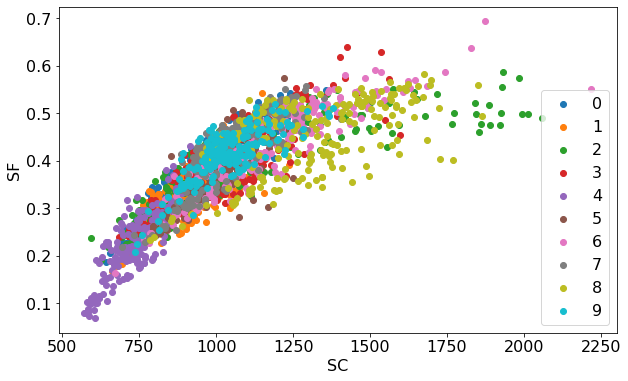

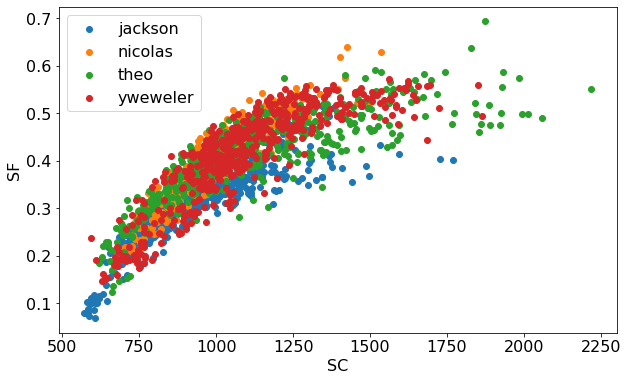

In [38]:
# PLOT THE DATA BY DIGIT AND SPEAKER

xfeature = 'SC'
yfeature = 'SF'

for label in ['digit','speaker']:

  plt.figure()
  for lbl in np.sort(df[label].unique()):

    digit_df = df[df[label]==lbl]
    plt.scatter(digit_df[xfeature],digit_df[yfeature],label='{}'.format(lbl))
    plt.xlabel(xfeature)
    plt.ylabel(yfeature)

  plt.legend()

# Train Machine Learning Algorithm

In [39]:
# Turn speaker names into categories [0,1,2]


label = 'speaker'
features = list(set(df.columns)-set([label,'file','trial','speaker_code']))

df.speaker = pd.Categorical(df.speaker)
df.digit = pd.Categorical(df.digit)
df.trial = pd.Categorical(df.trial)

if 'speaker' in features:
  
  df['speaker_code'] = df.speaker.cat.codes
  
  features.remove('speaker')
  features.append('speaker_code')
  features = list(set(features))

y = df[label]
X = df.loc[:,features]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   file     2000 non-null   object  
 1   digit    2000 non-null   category
 2   speaker  2000 non-null   category
 3   trial    2000 non-null   category
 4   SC       2000 non-null   float64 
 5   SF       2000 non-null   float64 
 6   MF       2000 non-null   float64 
dtypes: category(3), float64(3), object(1)
memory usage: 72.0+ KB


In [40]:
from sklearn.model_selection import train_test_split

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [41]:
# train a logistic regression model on the training set
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# instantiate model
model = DecisionTreeClassifier(max_depth=4)

# fit model
model.fit(X_train, y_train)



DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

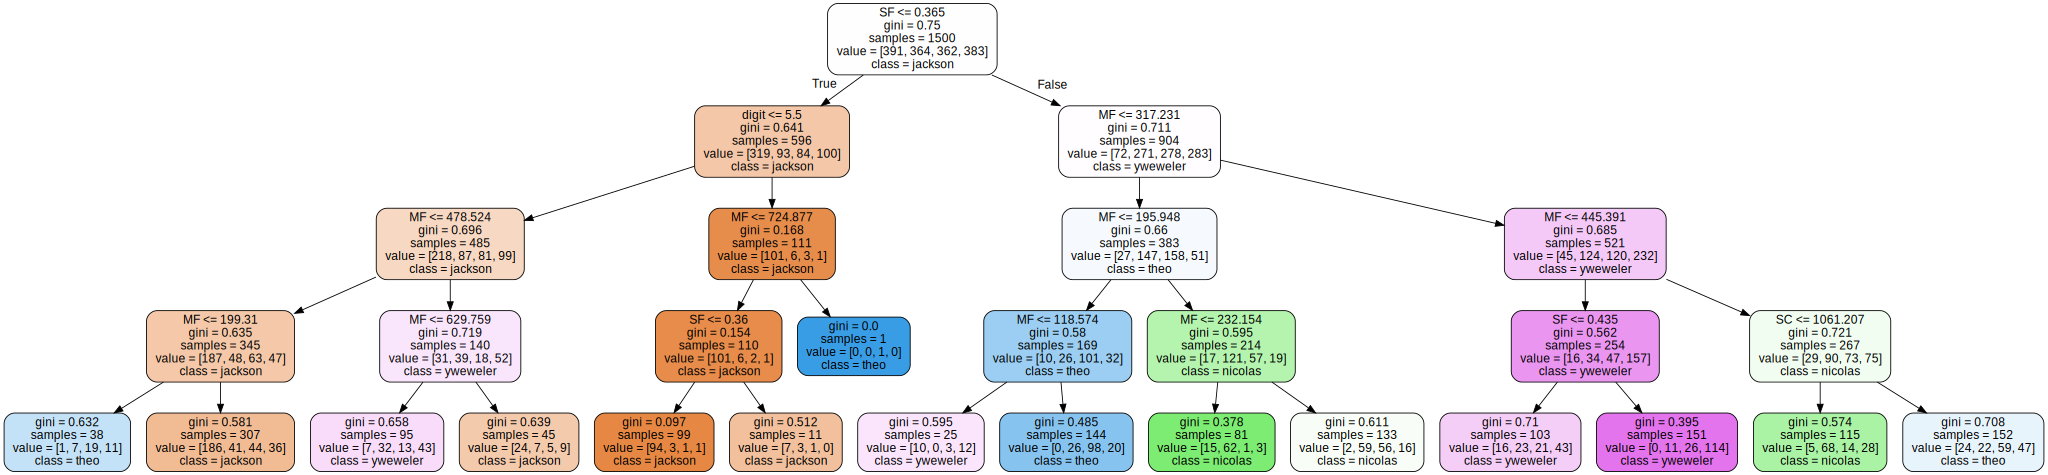

In [42]:
class_names = [str(c) for c in model.classes_]

# visualize the decision tree
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=features,  
                         class_names=class_names,  
                         filled=True, rounded=True) 

graph = graphviz.Source(dot_data)  
graph 

## Evaluate on Test Data

In [43]:
# Visualize the confusion matrix
def plot_cmatrix(cm,labels,title='Confusion Matrix'):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm,cmap='Reds')
  plt.title('\n'+title+'\n', fontsize=20)
  fig.colorbar(cax)
  ax.set_xticks(range(len(labels)))
  ax.set_yticks(range(len(labels)))
  ax.set_xticklabels(labels, fontsize=16)
  ax.set_yticklabels(labels, fontsize=16)
  plt.xlabel('Predicted', fontsize=16)
  plt.ylabel('True', fontsize=16)
  plt.show()

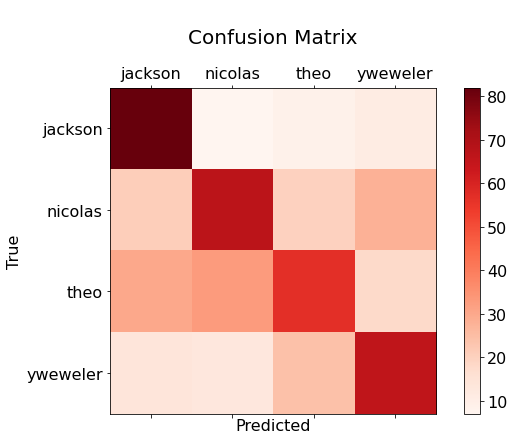

In [44]:
# Predict class label probabilities
labels=np.sort(y_test.unique())
y_test_pred = model.predict(X_test)

cm = metrics.confusion_matrix(y_test,y_test_pred, labels)
plot_cmatrix(cm, labels)